# OBJECTIVES

## 1) Finish cleaning dataset
- replace values
- remove 'CL' and turn to ints- done

## 2) Scatter Plots/Sub Plots
- each personality vs each drug
- each personality score vs number of cl
- demographics vs cl and drugs

## 3) Machine learning
- test x features (5 ft of personality) against each drug
- test x features (5 ft of personality) against each cl
- lasso or similar regressor to determine importance of demographics
- is there a personality trait that most influences drug use??


In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import numpy as np


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# DATA CLEANING

In [2]:
columns = ["ID", "age", "sex", "education", "country", "ethinicity", "Nscore", "Escore",
           "Oscore", "Ascore", "Cscore", "impulsive", "SS", "alcohol", "amphet", "amyl",
           "benzos", "caff", "cannabis", "chocolate", "cocaine", "crack", "ecstasy", "heroin",
           "ketamine", "legalh", "LSD", "meth", "mushrooms", "nicotine", "semer", "VSA"]

df_drug = pd.read_csv("drug_consumption.data", names=columns)
df_drug.head()


,ID,age,sex,education,country,ethinicity,Nscore,Escore,Oscore,Ascore,...,ecstasy,heroin,ketamine,legalh,LSD,meth,mushrooms,nicotine,semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [3]:
# set female to 0, male to 1
df_drug['sex'] = df_drug['sex'].mask(
    df_drug['sex'] == 0.48246, 0).mask(df_drug['sex'] == -0.48246, 1)


In [4]:
# age dictionary
age_range = {-0.95197: '18-24',
             -0.07854: '25-34',
             0.49788: '35-44',
             1.09449: '45-45',
             1.82213: '55-64',
             2.59171: '65+'}

# education dictionary
education = {-2.43591: "left school before 16 years",
             -1.7379: "left school at 16 years",
             -1.43719: "left school at 17 years",
             -1.22751: "left scoool at 18 years",
             -0.61113: "some college or university, no college or degree",
             -0.05921: "professional certificate/diploma",
             0.45468: "university degree",
             1.16365: "masters degree",
             1.98437: "doctorate degree"}

# country dictionary
country = {-0.09765: "Australia",
           0.24923: "Canada",
           -0.46841: "New Zealand",
           -0.28519: "Other Country",
           0.21128: "Republic of Ireland",
           0.96082: "UK",
           -0.57009: "USA"}

# ethinicity dictionary
ethinicity = {-0.50212: "Asian",
              -1.10702: "Black",
              1.90725: "Mixed - Black/Asian",
              0.126: "Mixed - White/Asian",
              -0.22166: "Mixed - White/Black",
              0.1144: "Other Ethinicity",
              -0.31685: "White"}


In [5]:
url = 'https://archive.ics.uci.edu/dataset/373/drug+consumption+quantified'
str_html = requests.get(url).text
soup = BeautifulSoup(str_html)
text = soup.find_all("p")[13].text

In [6]:
def float_to_string(value):
    """ convert values to floats, regardless of presence of a percentage sign 

    Arguments:
        value (str): value to be converted to a float

    Returns:
        float(value) (float): converted value
    """

    # check if value ends with a percentage sign
    if isinstance(value, str) and value.endswith('%'):
        # remove % sign, convert to float
        value = float(value.rstrip('%'))

    # convert value to float
    return float(value)


In [7]:
# TODO - this function is not used, remove if it is never needed
def FF_codes_df(start, end):
    """ converts a string segment into an organized dataframe

    Arguments:
        start (str): beginning of desired string segment
        end (str): ending of desired string segment

    Returns:
        score_df (pandas dataframe): final organized dataframe
    """

    # initialize dataframe
    score_df = pd.DataFrame(columns=["score", "cases", "value"])

    # isolate desired segment
    start_idx = text.index(start)
    end_idx = text.index(end)
    segment = text[start_idx:end_idx].splitlines()

    for line in segment[2:]:
        if line == "     Descriptive statistics":
            break

        else:
            # split each line into a list
            line_ls = line.split()

            count = 0
            for element in line_ls:

                # if value is the first of a triplet, add it to score column
                if count == 0:
                    score_df.loc[len(score_df)] = [
                        float_to_string(element), None, None]
                    

                # if value is the second of a triplet, add it to score column
                elif count == 1:
                    score_df.loc[len(score_df) - 1,
                                 "cases"] = float_to_string(element)

                # if value is the third of a triplet, add it to score column
                elif count == 2:
                    score_df.loc[len(score_df) - 1,
                                 "value"] = float_to_string(element)
                    count = -1
                count += 1
    score_df = score_df.sort_values(
        by="score").reset_index().drop(columns=["index"])
    return score_df


In [8]:
def FF_codes(start, end):
    """ converts a string segment into a dictionary where the keys are coded values 
        and values are the actual scores

    Arguments:
        start (str): beginning of desired string segment
        end (str): ending of desired string segment

    Returns:
        score_dict (dict): final organized dictionary
    """

    # initialize dataframe
    score_df = pd.DataFrame(columns=["score", "cases", "value"])

    # isolate desired segment
    start_idx = text.index(start)
    end_idx = text.index(end)
    segment = text[start_idx:end_idx].splitlines()
    score_dict = {}

    for line in segment[2:]:
        if line == "     Descriptive statistics":
            break

        else:
            # split each line into a list
            line_ls = line.split()

            # add scores and values to dicitonary
            score_dict[float(line_ls[2])] = float(line_ls[0])

            if len(line_ls)/3 == 2:
                score_dict[float(line_ls[5])] = float(line_ls[3])

            if len(line_ls)/3 == 3:
                score_dict[float(line_ls[5])] = float(line_ls[3])
                score_dict[float(line_ls[8])] = float(line_ls[6])

    return score_dict

In [9]:
nscore = FF_codes("7. Nscore (Real) is NEO-FFI-R Neuroticism.",
                  "8. Escore (Real) is NEO-FFI-R Extraversion.")
escore = FF_codes("8. Escore (Real) is NEO-FFI-R Extraversion.",
                  "9. Oscore (Real) is NEO-FFI-R Openness to experience.")
oscore = FF_codes("9. Oscore (Real) is NEO-FFI-R Openness to experience.",
                  "10. Ascore (Real) is NEO-FFI-R Agreeableness.")
ascore = FF_codes("10. Ascore (Real) is NEO-FFI-R Agreeableness.",
                  "11. Cscore (Real) is NEO-FFI-R Conscientiousness.")
cscore = FF_codes("11. Cscore (Real) is NEO-FFI-R Conscientiousness.",
                  "12. Impulsive (Real) is impulsiveness measured by BIS-11.")
#impulsive = FF_codes("12. Impulsive (Real) is impulsiveness measured by BIS-11.","13. SS (Real) is sensation seeing measured by ImpSS.")
#ss_percentage = FF_codes("13. SS (Real) is sensation seeing measured by ImpSS.","14. Alcohol is class of alcohol consumption.")
# TODO - analyze impulsiveness and ss?

In [10]:
def drug_codes(start, end):
    """ converts a string segment into an organized dataframe

    Arguments:
        start (str): beginning of desired string segment
        end (str): ending of desired string segment

    Returns:
        drug_df (pandas dataframe): final organized dataframe
    """

    # initialize dataframe
    to_concat = []
    cl = ["CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"]

    # isolate desired segment
    start_idx = text.index(start)
    if end == "end":
        end_idx = len(text) - 2
    else:
        end_idx = text.index(end)
    segment = text[start_idx:end_idx].splitlines()
    if end == "end":
        limit = segment[3:]
    else:
        limit = segment[3:-1]

    # get list of represented drugs
    drugs = segment[1].split()[2:]

    for line in limit:

        # isolate only numbers
        line_ls = line.split()[-8:]
        if end == "end":
            line_ls = line_ls[2:]
        
        # get pairs of cases and fractions
        if segment[1:].index(line) != 1:
            segmented_line_ls = [line_ls[:2], line_ls[2:4], line_ls[4:6]]
            if end != "end":
                segmented_line_ls.append(line_ls[6:8])
            
            # add pairs to dataframe
            for i in range(len(cl)):
                if i < len(segmented_line_ls):
                    c = cl[segment[1:].index(line) - 2]
                    pair = segmented_line_ls[i]
                    drug = drugs[i]
                    cases, fraction = pair

                    # create dictionary for row data
                    row_data = {"class": c, "drug": drug, "cases": float_to_string(
                        cases), "fraction": float_to_string(fraction)}

                    # add row to dataframe
                    to_concat.append(pd.DataFrame([row_data]))

    drug_df = pd.concat(to_concat, ignore_index=True)
    return drug_df


In [11]:
# collect all drug information
drug_set_1 = drug_codes("17. Benzos is class of benzodiazepine consumption.",
                        "18. Caff is class of caffeine consumption.")
drug_set_2 = drug_codes("21. Coke is class of cocaine consumption.",
                        "22. Crack is class of crack consumption.")
drug_set_3 = drug_codes("25. Ketamine is class of ketamine consumption.",
                        "26. Legalh is class of legal highs consumption.")
drug_set_4 = drug_codes("29. Mushrooms is class of magic mushrooms consumption.",
                        "30. Nicotine is class of nicotine consumption.")
drug_set_5 = drug_codes("32. VSA is class of volatile substance abuse consumption.",
                        "end")

dataframes = [drug_set_1, drug_set_2, drug_set_3, drug_set_4, drug_set_5]
df_drug_use = pd.concat(dataframes, ignore_index=True)

In [12]:
ls_drugs = ["alcohol", "amphet", "amyl",
            "benzos", "caff", "cannabis", "chocolate", "cocaine", "crack", "ecstasy", "heroin",
            "ketamine", "legalh", "LSD", "meth", "mushrooms", "nicotine", "semer", "VSA"]


In [13]:
# replace CLs with their numerical value
for column in df_drug.columns[13:]:  # Assuming the drug columns start from the 6th column
    df_drug[column] = df_drug[column].str.replace('CL', '').astype(int)

In [14]:
# replace FF scores
"""df_drug["Nscore"] = df_drug["Nscore"].replace(nscore)
df_drug["Escore"] = df_drug["Escore"].replace(escore)
df_drug["Oscore"] = df_drug["Oscore"].replace(oscore)
df_drug["Ascore"] = df_drug["Ascore"].replace(ascore)
df_drug["Cscore"] = df_drug["Cscore"].replace(cscore)
df_drug.head(2)"""

'df_drug["Nscore"] = df_drug["Nscore"].replace(nscore)\ndf_drug["Escore"] = df_drug["Escore"].replace(escore)\ndf_drug["Oscore"] = df_drug["Oscore"].replace(oscore)\ndf_drug["Ascore"] = df_drug["Ascore"].replace(ascore)\ndf_drug["Cscore"] = df_drug["Cscore"].replace(cscore)\ndf_drug.head(2)'

In [15]:
# replace ages
"""df_drug["age"] = df_drug["age"].replace(age_range)

# replace education
df_drug["education"] = df_drug["education"].replace(education)

# replace country
df_drug["country"] = df_drug["country"].replace(country)

# replace ethinicity
df_drug["ethinicity"] = df_drug["ethinicity"].replace(ethinicity)

df_drug.head()"""

'df_drug["age"] = df_drug["age"].replace(age_range)\n\n# replace education\ndf_drug["education"] = df_drug["education"].replace(education)\n\n# replace country\ndf_drug["country"] = df_drug["country"].replace(country)\n\n# replace ethinicity\ndf_drug["ethinicity"] = df_drug["ethinicity"].replace(ethinicity)\n\ndf_drug.head()'

In [16]:
# save cleaned dataframe to csv
df_drug.to_csv('cleaned_drug_consumption.csv', index=False)

# VISUALIZATIONS

In [17]:
all_drugs =  ["alcohol", "amphet", "amyl",
            "benzos", "caff", "cannabis", "chocolate", "cocaine", "crack", "ecstasy", "heroin",
            "ketamine", "legalh", "LSD", "meth", "mushrooms", "nicotine","semer", "VSA"]

In [18]:
df_drug['avg drug frequency'] = df_drug[ls_drugs].mean(axis=1)

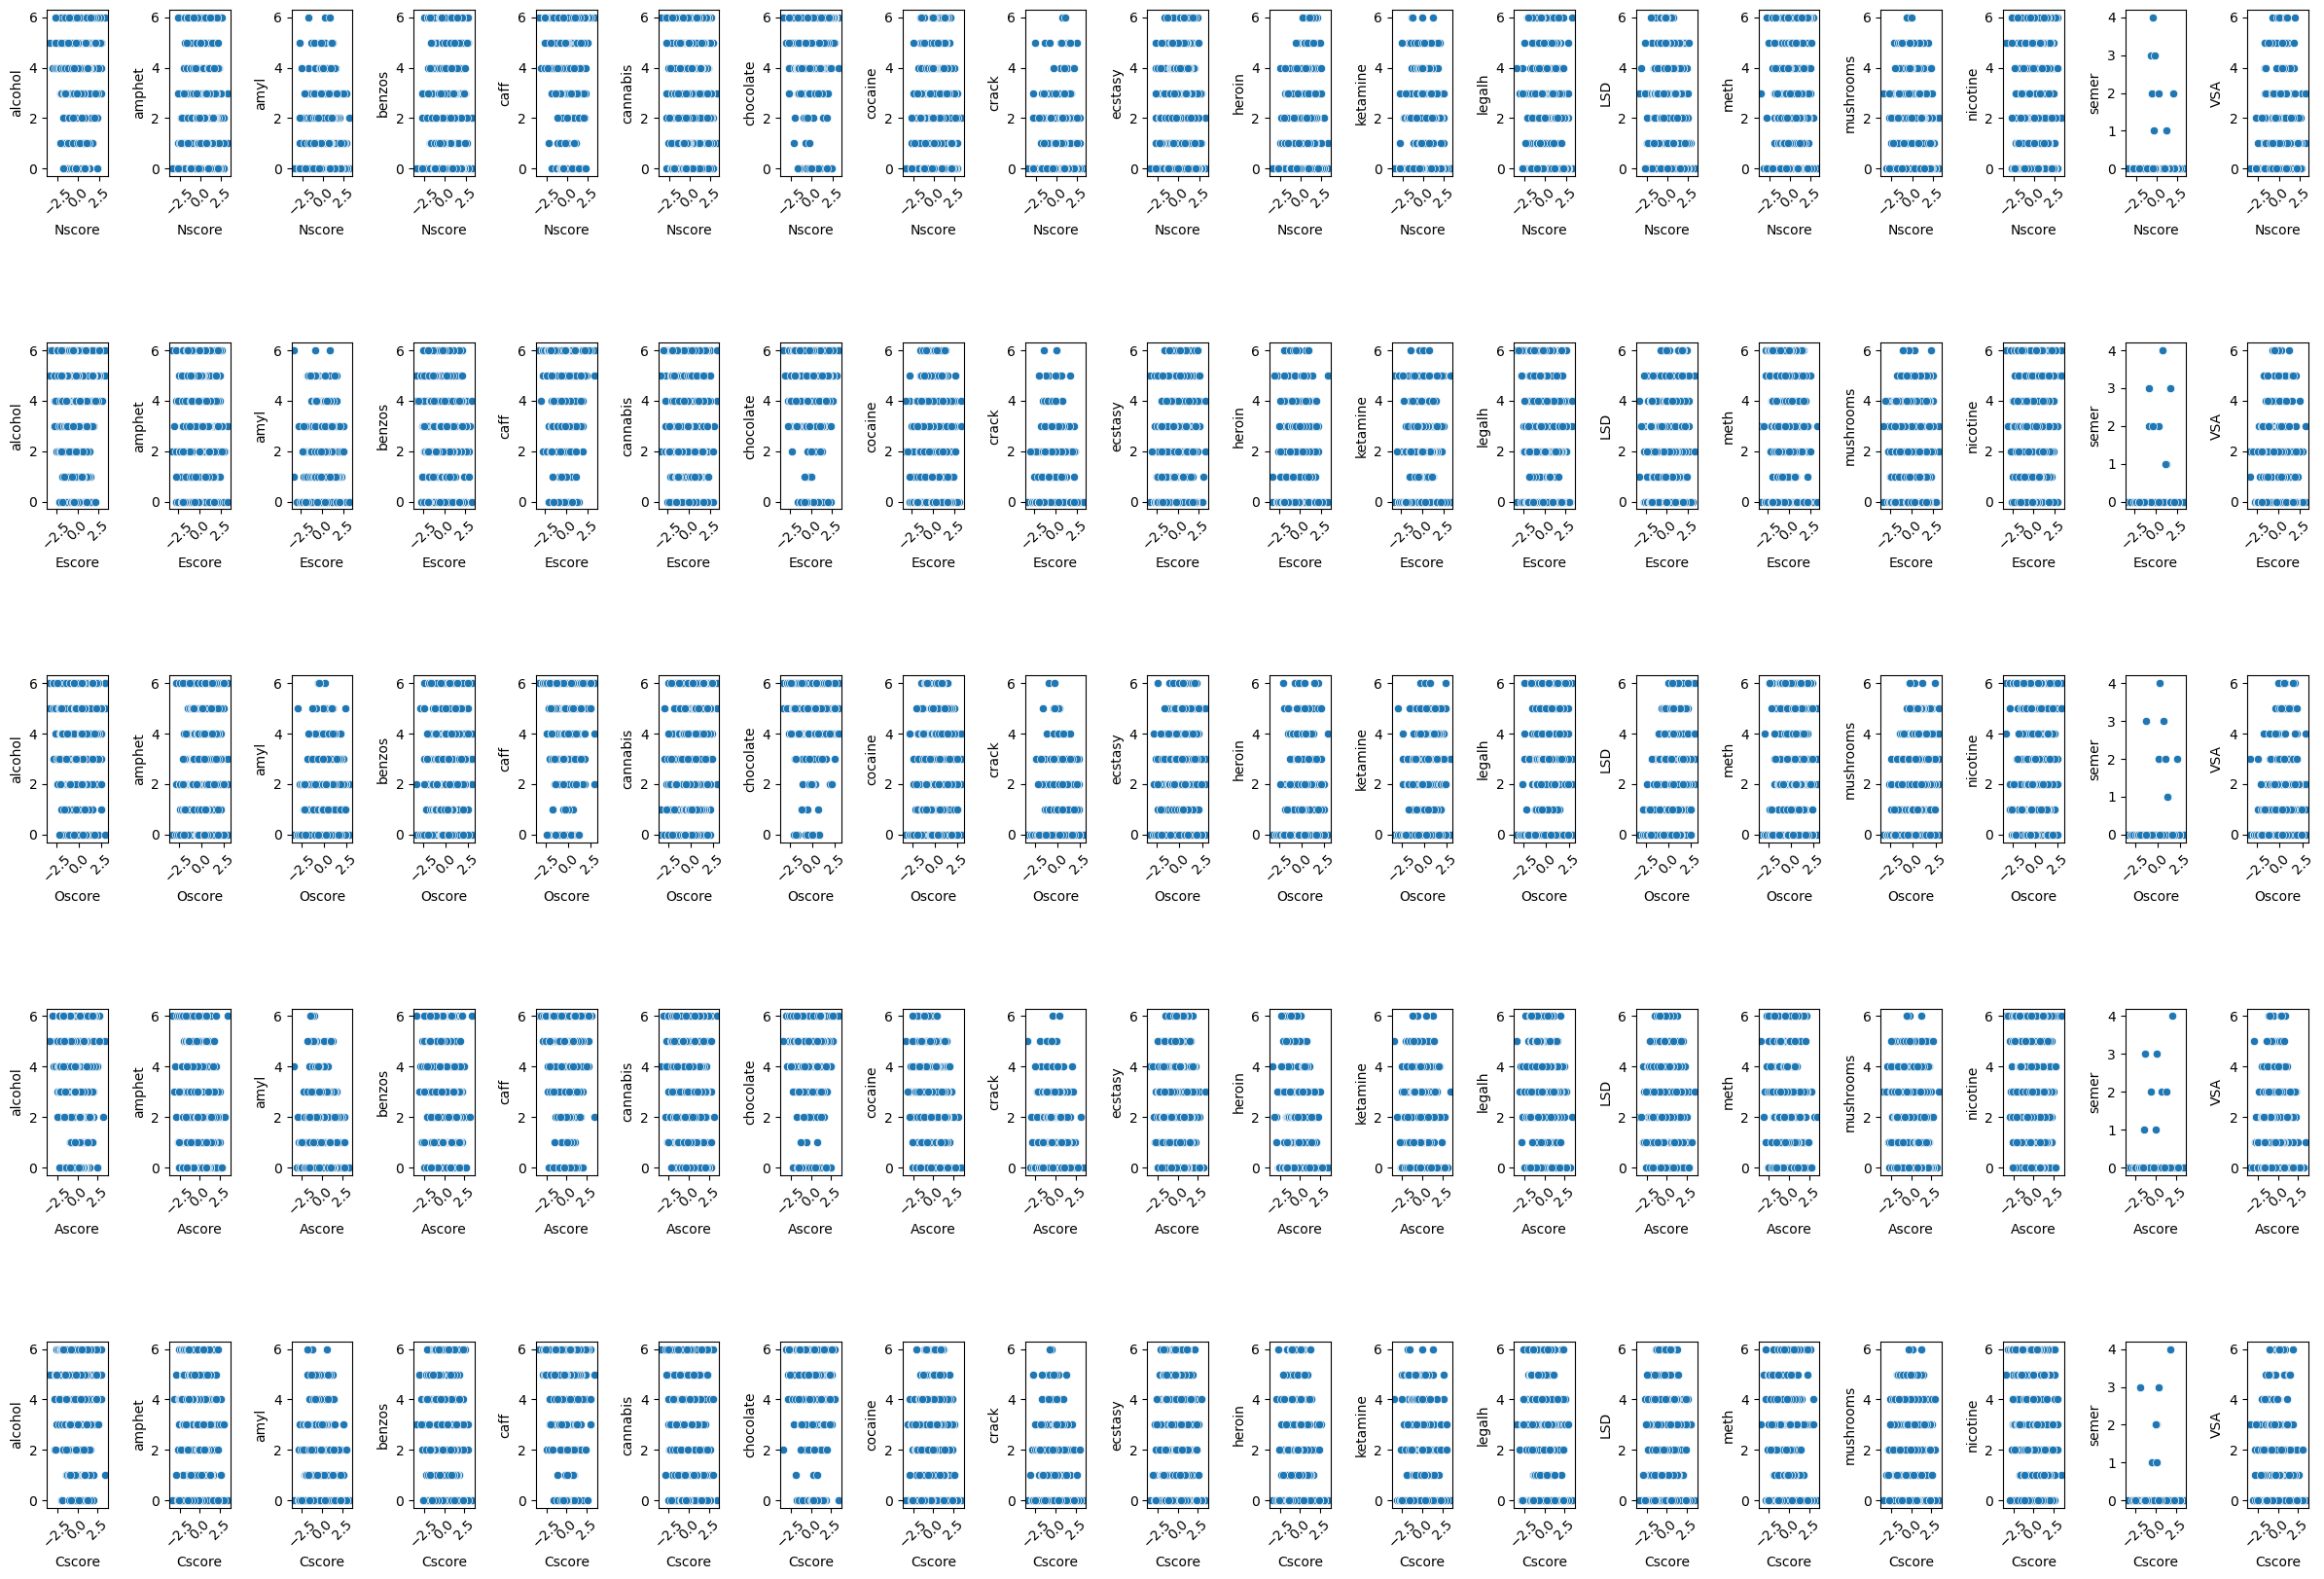

In [19]:
df = df_drug

# Define the list of personality score columns
personality_scores = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore']

# Define the list of drug columns
drug_columns = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'chocolate', 'cocaine',
                'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'LSD', 'meth', 'mushrooms',
                'nicotine', 'semer', 'VSA']

# Create subplots for personality scores vs. each drug
fig, axes = plt.subplots(nrows=len(personality_scores), ncols=len(drug_columns), figsize=(30, 20))
fig.subplots_adjust(wspace=1, hspace=1)

for i, personality_score in enumerate(personality_scores):
    for j, drug in enumerate(drug_columns):
        sns.scatterplot(x=personality_score, y=drug, data=df, ax=axes[i, j])
        #axes[i, j].set_title(f'{personality_score} vs {drug}', fontsize=8)
        axes[i, j].set_xlabel(personality_score)
        axes[i, j].set_ylabel(drug)
        axes[i, j].tick_params(axis='x', labelrotation=45)

# MACHINE LEARNING

In [20]:
df_drug = df_drug / df_drug.std()

/Users/sahanadhar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


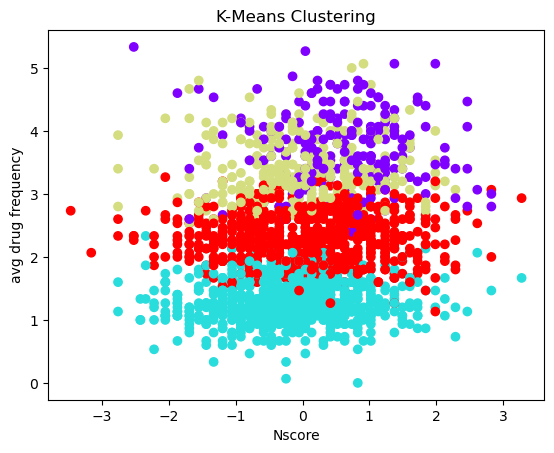

In [21]:
# Select the features for clustering (personality traits and drug frequencies)
X = df_drug[['Nscore', 'Ascore', 'Cscore', 'Escore', 'Oscore',
          'alcohol', 'amphet', 'amyl', 'benzos', 'caff',
          'cannabis', 'chocolate', 'cocaine', 'crack', 'ecstasy',
          'heroin', 'ketamine', 'legalh', 'LSD', 'meth',
          'mushrooms', 'nicotine', 'VSA', 'avg drug frequency']]

# Define the number of clusters (you can adjust this based on your needs)
num_clusters = 4

# Create a KMeans clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model to your data
kmeans.fit(X)

# Add the cluster labels to your dataset
df_drug['Cluster_Labels'] = kmeans.labels_

# Visualize the clusters (example plot)
# You may need to adapt the visualization to your specific dataset
plt.scatter(X['Nscore'], X['avg drug frequency'], c=df_drug['Cluster_Labels'], cmap='rainbow')
plt.xlabel('Nscore')
plt.ylabel('avg drug frequency')
plt.title('K-Means Clustering')
plt.show()

Polynomial Equation:
y = 2.16 + -0.00 * X[0 0 0 0 0] + 0.18 * X[1 0 0 0 0] + -0.12 * X[0 1 0 0 0] + -0.41 * X[0 0 1 0 0] + 0.09 * X[0 0 0 1 0] + 0.50 * X[0 0 0 0 1] + -0.02 * X[2 0 0 0 0] + -0.02 * X[1 1 0 0 0] + -0.04 * X[1 0 1 0 0] + 0.03 * X[1 0 0 1 0] + -0.03 * X[1 0 0 0 1] + 0.03 * X[0 2 0 0 0] + 0.01 * X[0 1 1 0 0] + -0.02 * X[0 1 0 1 0] + 0.02 * X[0 1 0 0 1] + -0.01 * X[0 0 2 0 0] + -0.02 * X[0 0 1 1 0] + 0.04 * X[0 0 1 0 1] + 0.05 * X[0 0 0 2 0] + 0.02 * X[0 0 0 1 1] + 0.01 * X[0 0 0 0 2] + -0.03 * X[3 0 0 0 0] + -0.03 * X[2 1 0 0 0] + 0.03 * X[2 0 1 0 0] + -0.01 * X[2 0 0 1 0] + -0.02 * X[2 0 0 0 1] + -0.00 * X[1 2 0 0 0] + -0.02 * X[1 1 1 0 0] + 0.01 * X[1 1 0 1 0] + 0.01 * X[1 1 0 0 1] + 0.03 * X[1 0 2 0 0] + 0.02 * X[1 0 1 1 0] + -0.01 * X[1 0 1 0 1] + -0.05 * X[1 0 0 2 0] + 0.05 * X[1 0 0 1 1] + -0.03 * X[1 0 0 0 2] + 0.00 * X[0 3 0 0 0] + 0.01 * X[0 2 1 0 0] + -0.03 * X[0 2 0 1 0] + -0.01 * X[0 2 0 0 1] + -0.03 * X[0 1 2 0 0] + 0.07 * X[0 1 1 1 0] + -0.04 * X[0 1 1 0 1] +

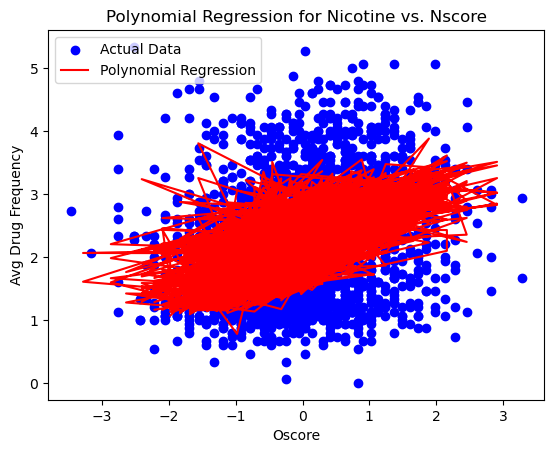

In [22]:
# Extract the relevant columns
X = df_drug[['Nscore', 'Ascore', 'Cscore', 'Escore', 'Oscore']]
y = df_drug['avg drug frequency']

# Create a PolynomialFeatures object to transform features into polynomial form
degree = 3  # You can adjust the degree of the polynomial
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model with the polynomial features
model.fit(X_poly, y)

# Predict the values based on the model
y_pred = model.predict(X_poly)

# Print the coefficients of the polynomial equation
coefficients = model.coef_
intercept = model.intercept_
print("Polynomial Equation:")
equation = f'y = {intercept:.2f}'
for i in range(len(coefficients)):
    equation += f' + {coefficients[i]:.2f} * X{poly.powers_[i]}'

print(equation)

# Plot the data and the regression curve
plt.scatter(X['Nscore'], y, label='Actual Data', c='blue')
plt.plot(X['Oscore'], y_pred, label='Polynomial Regression', c='red')
plt.xlabel('Oscore')
plt.ylabel('Avg Drug Frequency')
plt.title('Polynomial Regression for Nicotine vs. Nscore')
plt.legend()
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_drug[['Nscore', 'Ascore', 'Cscore', 'Escore', 'Oscore']]
y = df_drug['avg drug frequency']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model's coefficients and evaluation metrics
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Coefficients: [ 0.04212186 -0.1481585  -0.26096802  0.02646726  0.36939304]
Intercept: 2.229378548644978
Mean Squared Error: 0.7819963619074466
R-squared: 0.21590747593884296


## FEATURE SELECTION

In [24]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X = df_drug[['Nscore', 'Ascore', 'Cscore', 'Escore', 'Oscore']]
y = df_drug['avg drug frequency']

# Create a Linear Regression model
model = LinearRegression()

# Specify the number of features to select (you can adjust this value)
num_features_to_select = 3

# Perform RFE to select the most relevant features
rfe = RFE(model, n_features_to_select=num_features_to_select)
fit = rfe.fit(X, y)

# Get the selected features
selected_features = [col for col, support in zip(X.columns, fit.support_) if support]

# Print the selected features
print("Selected Features:", selected_features)

Selected Features: ['Ascore', 'Cscore', 'Oscore']


## DECISION TREE

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = df_drug[['Nscore', 'Ascore', 'Cscore', 'Escore', 'Oscore']]
y = df_drug['heroin']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 2.184902147444179
R-squared: -1.1630866108949922
